In [2]:
from functools import partial
from itertools import combinations

from craterdetection.matching.database import CraterDatabase, load_craters, extract_robbins_dataset, crater_representation, CoplanarInvariants
from astropy.coordinates import spherical_to_cartesian, cartesian_to_spherical

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import networkx as nx
import sklearn.neighbors

In [3]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id_cat = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[4, 30])
)

In [4]:
R_moon = 1737.4
x_cat, y_cat, z_cat = map(np.array, spherical_to_cartesian(R_moon, lat_cat, long_cat))

adjacency_matrix = sklearn.neighbors.radius_neighbors_graph(np.array([x_cat, y_cat, z_cat]).T, 200,
                                                                  mode='connectivity',
                                                                  metric='euclidean', n_jobs=-1)

graph = nx.from_scipy_sparse_matrix(adjacency_matrix)
crater_triads = np.array([c for c in nx.cycle_basis(graph) if len(c) == 3])

In [81]:
x, y, z = map(np.array, spherical_to_cartesian(R_moon, lat_cat[crater_triads], long_cat[crater_triads]))
avg_x, avg_y, avg_z = map(partial(np.mean, axis=-1), (x, y, z))

p_centroid = np.array([avg_x, avg_y, avg_z])[:, None].transpose(2, 0, 1)

k = np.array([0, 0, 1])[:, None]

u_i = p_centroid / R_moon

e_i = np.cross(k[None, ...], u_i, axis=1)
e_i /= LA.norm(e_i, ord=2, axis=(1, 2))[:, None, None]

n_i = np.cross(u_i, e_i, axis=1)
n_i /= LA.norm(n_i, ord=2, axis=(1, 2))[:, None, None]

T_ME = LA.inv(np.concatenate((e_i, n_i, u_i), axis=-1))
T_ME

array([[[-5.15643101e-02, -9.98669676e-01, -0.00000000e+00],
        [ 8.78175673e-01, -4.53428434e-02,  4.76184328e-01],
        [-4.76055592e-01,  2.45801778e-02,  8.80278812e-01]],

       [[-5.88635335e-02, -9.98266039e-01, -3.47547329e-18],
        [ 8.77305040e-01, -5.17309741e-02,  4.77137059e-01],
        [-4.76816102e-01,  2.81158324e-02,  8.79763205e-01]],

       [[-3.73984557e-02, -9.99300433e-01,  3.47187576e-18],
        [ 8.80922453e-01, -3.29682028e-02,  4.72110929e-01],
        [-4.72313900e-01,  1.76761761e-02,  8.82535533e-01]],

       ...,

       [[ 1.94939436e-01, -9.80815281e-01,  1.41492369e-17],
        [ 8.54216265e-01,  1.69777572e-01,  4.91416472e-01],
        [-4.82594444e-01, -9.59168262e-02,  8.72019100e-01]],

       [[ 1.85612600e-01, -9.82623001e-01, -2.82464135e-17],
        [ 8.51019261e-01,  1.60753307e-01,  4.99924586e-01],
        [-4.91804149e-01, -9.28993585e-02,  8.67068143e-01]],

       [[ 1.89153784e-01, -9.81947476e-01, -0.00000000e+00],
 

In [82]:
dx, dy, dz = x - avg_x[:, None], y - avg_y[:, None], z - avg_z[:, None]
delta_pos = np.concatenate((dx[None, :], dy[None, :], dz[None, :]), axis=0).T[..., None]
ENU_pos = T_ME @ delta_pos
np.mean(np.abs(ENU_pos[..., 2, 0])) / np.mean(np.abs(ENU_pos[..., 0, 0]))

0.01613888446232717

In [83]:
ENU_pos[:, :, 0, 0].shape

(3, 4389472)

In [84]:
A_i, A_j, A_k = map(crater_representation,
    ENU_pos[..., 0, 0],
    ENU_pos[..., 1, 0],
    major_cat[crater_triads].T,
    minor_cat[crater_triads].T,
    psi_cat[crater_triads].T
    )

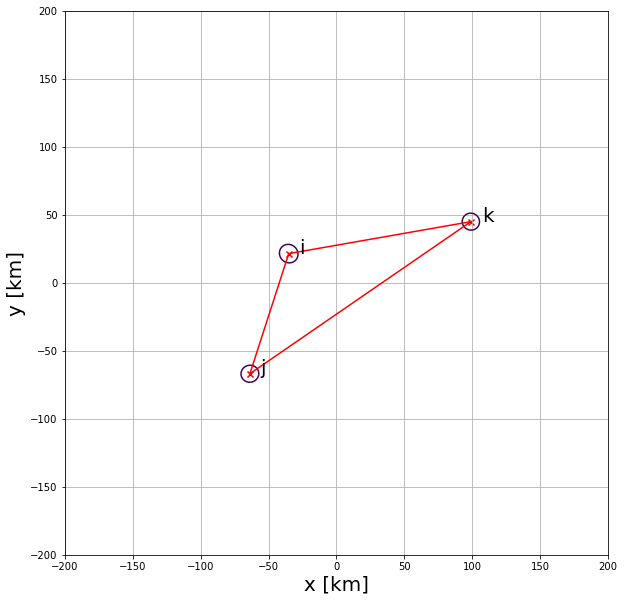

In [85]:
x_plot = np.linspace(-200, 200, 500)
y_plot = np.linspace(-200, 200, 500)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

xy_homogeneous = np.concatenate(
    (
        x_plot.ravel()[None, :],
        y_plot.ravel()[None, :],
        np.ones_like(x_plot.ravel()[None, :])
    ),
    axis=0
).T[..., None]

i = 789

x_craters = ENU_pos[:, i, 0, 0]
y_craters = ENU_pos[:, i, 1, 0]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 'equal'})

for a_i in [A_i[i], A_j[i], A_k[i]]:
    c = xy_homogeneous.transpose(0, 2, 1) @ a_i @ xy_homogeneous
    ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0])
ax.scatter(x_craters, y_craters, c='r', marker='x')

for pair_i in combinations([0, 1, 2], 2):
    pair_i = list(pair_i)
    ax.plot(x_craters[pair_i], y_craters[pair_i], c='r')

for k, label in enumerate(['i', 'j', 'k']):
    ax.text(x_craters[k]+8, y_craters[k], label, size=20)

ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_ylabel('y [km]', size=20)
ax.set_xlabel('x [km]', size=20)
ax.grid(which='both')

fig.savefig('output/crater_triad.png')

In [116]:
from craterdetection.common.camera import Camera
from craterdetection.common.projection import project_craters, crater_camera_homography
from craterdetection.common.coordinates import ENU_system

lat, long = cartesian_to_spherical(*p_centroid[i].ravel())[1:]
C_i = np.concatenate((A_i[i][None, ...], A_j[i][None, ...], A_k[i][None, ...]), axis=0)
p_triad = np.array(spherical_to_cartesian(R_moon, lat_cat[crater_triads[i]], long_cat[crater_triads[i]])).T[..., None]

cam1 = Camera.from_coordinates(lat.value, long.value, altitude=700, fov=45, resolution=(1000, 1000), convert_to_radians=False)
cam2 = Camera.from_coordinates(lat.value, long.value, altitude=3000, fov=30, resolution=(1000, 1000), convert_to_radians=False)

H_Ci1 = crater_camera_homography(p_triad, cam1.P())
T1 = LA.inv(H_Ci1)
A_iii1 =  T1.transpose(0, 2, 1) @ C_i @ T1

H_Ci2 = crater_camera_homography(p_triad, cam2.P())
T2 = LA.inv(H_Ci2)
A_iii2 =  T2.transpose(0, 2, 1) @ C_i @ T2

In [117]:
CoplanarInvariants(crater_triads[i], *A_iii1).get_pattern()

array([[  -786.53671956,   -828.01495477,  -1611.99967252,
         -1763.75233313,  -4058.02428628,  -3958.8592417 ,
        -12530.86098182]])

In [118]:
CoplanarInvariants(crater_triads[i], *A_iii2).get_pattern()


array([[  -782.94491606,   -825.84342569,  -1594.20112687,
         -1749.55899188,  -3958.73430634,  -3863.34673903,
        -12254.22121293]])